# End‑to‑End Customer Churn Modeling (v10 – balanced & stacked)
This notebook is an **updated, self‑contained pipeline** that:
1. Loads and cleans the churn dataset  
2. Performs date parsing & feature engineering  
3. Prunes constant / highly‑correlated features  
4. Splits data into train / test  
5. **Undersamples** the majority class to obtain a 50 / 50 balance in the *training* fold  
6. Trains a **stacking ensemble** on that balanced set  
7. Tunes the decision **threshold** on the training data to maximise *F1*  
8. Evaluates on the **original, imbalanced test set** with full metrics & curves.

*(c) 2024 – update requested by user to improve recall on minority class.*

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings, os, itertools
from itertools import combinations, permutations
from pandas.api.types import is_datetime64_any_dtype
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, precision_recall_curve,
                             roc_auc_score, roc_curve)
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
plt.rcParams['figure.dpi'] = 110

## 1 — Load data & basic cleaning

In [5]:
DATA_PATH = 'merged_churn_dataset.csv'  # path to full dataset
df = pd.read_csv(DATA_PATH)

# remove any unnamed index cols
df = df.drop(columns=[c for c in df.columns if 'Unnamed' in c])

# keep only examples with churn label
df = df[df['churn'].notna()].copy()
df['churn'] = df['churn'].astype(int)
print('Dataset shape after label keep:', df.shape)

Dataset shape after label keep: (14606, 56)


## 2 — Date parsing ➜ numeric & calendar features

In [8]:
date_cols = [c for c in df.columns if is_datetime64_any_dtype(df[c]) or 'date' in c.lower()]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce')
    df[c+'_ts'] = df[c].view('int64') // 10**9
    df[c+'_year']  = df[c].dt.year
    df[c+'_month'] = df[c].dt.month
    df[c+'_day']   = df[c].dt.day
    df[c+'_week']  = df[c].dt.isocalendar().week.astype(int)

# drop original date columns
df = df.drop(columns=date_cols)

# one‑hot encode `channel_sales`
df['channel_sales'] = df['channel_sales'].astype('category')
print('After date engineering:', df.shape)

After date engineering: (14606, 72)


## 3 — Optional numeric feature engineering (pairwise ratios & diffs)
*⚠️ Skip or adjust if computationally heavy for your environment.*

In [11]:
numeric_base = [c for c in df.columns if c not in ['id', 'churn', 'channel_sales']
                and pd.api.types.is_numeric_dtype(df[c])]
print('Numeric base feature count:', len(numeric_base))

# --- massive combinatorial expansion ---
eps = 1e-6
ratio_cols, diff_cols = {}, {}
for a, b in permutations(numeric_base, 2):
    ratio_cols[f'{a}_div_{b}'] = df[a] / (df[b] + eps)
for a, b in combinations(numeric_base, 2):
    diff_cols[f'{a}_minus_{b}'] = df[a] - df[b]

df = pd.concat([df, pd.DataFrame(ratio_cols), pd.DataFrame(diff_cols)], axis=1)
print('Shape after feature engineering:', df.shape)

Numeric base feature count: 67
Shape after feature engineering: (14606, 6705)


## 4 — Prune constant & highly‑correlated features

In [14]:
# Keep numeric only for correlation check
feature_cols = [c for c in df.columns if c not in ['id', 'churn', 'channel_sales']]
X_full = df[feature_cols].select_dtypes(include=[np.number])

# remove zero‑variance
vt = VarianceThreshold()
X_var = vt.fit_transform(X_full)
keep_var = X_full.columns[vt.get_support()]

# drop highly correlated (>0.95)
corr = pd.DataFrame(X_var, columns=keep_var).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] >= 0.95)]

pruned_features = [c for c in keep_var if c not in to_drop]
feature_cols_model = pruned_features + ['channel_sales']
print(f'Features after pruning: {len(pruned_features)}')

Features after pruning: 1137


## 5 — Train / test split (stratified)

In [17]:
X = df[feature_cols_model]
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Class distribution in train:', y_train.value_counts(normalize=True).round(3).to_dict())

Train shape: (11684, 1138) Test shape: (2922, 1138)
Class distribution in train: {0: 0.903, 1: 0.097}


## 6 — **Balance training set (undersample 0 ➜ 1 ratio = 1:1)**

In [20]:
train_tmp = X_train.copy()
train_tmp['churn'] = y_train.values

minor = train_tmp[train_tmp['churn'] == 1]
major = train_tmp[train_tmp['churn'] == 0]

major_down = resample(major,
                     replace=False,
                     n_samples=len(minor),
                     random_state=RANDOM_STATE)

train_bal = pd.concat([minor, major_down])
X_train_bal = train_bal.drop(columns='churn')
y_train_bal = train_bal['churn']

print('Balanced class counts:', y_train_bal.value_counts().to_dict())

Balanced class counts: {1: 1135, 0: 1135}


## 7 — Preprocessing pipeline

In [23]:
preproc = ColumnTransformer([
    ('num', StandardScaler(), pruned_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['channel_sales'])
])

## 8 — Define base learners & **Stacking ensemble**

In [26]:
base_models = [
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=RANDOM_STATE)),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE)),
    ('xgb', XGBClassifier(
        scale_pos_weight=1,  # balanced training makes this ~1
        eval_metric='logloss', use_label_encoder=False,
        n_estimators=300, learning_rate=0.1, max_depth=5,
        random_state=RANDOM_STATE, verbosity=0))
]

stack_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    n_jobs=-1, passthrough=False, cv=5
)

pipe = Pipeline([
    ('pre', preproc),
    ('clf', stack_clf)
])

## 9 — Fit ensemble on **balanced** training data

In [31]:
pipe.fit(X_train_bal, y_train_bal)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cons_12m', 'cons_gas_12m',
                                                   'forecast_cons_12m',
                                                   'forecast_cons_year',
                                                   'forecast_discount_energy',
                                                   'forecast_meter_rent_12m',
                                                   'forecast_price_energy_off_peak',
                                                   'forecast_price_energy_peak',
                                                   'forecast_price_pow_off_peak',
                                                   'margin_gross_pow_ele',
                                                   'nb_prod_act', 'net_margin',
                                                   'num_yea...
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=5,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=300,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...))],
                                    final_estimator=LogisticRegression(max_iter=1000,
                                                                       random_state=42),
                                    n_jobs=-1))])

## 10 — Tune probability threshold on train (F1 maximisation)

In [60]:
y_scores_train = pipe.predict_proba(X_train_bal)[:, 1]
prec, rec, thr = precision_recall_curve(y_train_bal, y_scores_train)
f1s = 2 * (prec * rec) / (prec + rec + 1e-6)
best_idx = np.argmax(f1s)
best_thr = thr[best_idx]
print(f'Optimal threshold = {best_thr:.2f}  |  F1 = {f1s[best_idx]:.2f}  |  Precision = {prec[best_idx]:.2f}  |  Recall = {rec[best_idx]:.2f}')

Optimal threshold = 0.47  |  F1 = 1.00  |  Precision = 1.00  |  Recall = 1.00


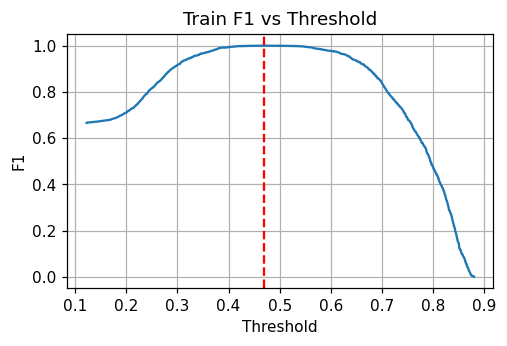

In [62]:

# Plot F1 vs threshold
plt.figure(figsize=(5,3))
plt.plot(thr, f1s[:-1])
plt.axvline(best_thr, color='r', ls='--')
plt.xlabel('Threshold'); plt.ylabel('F1'); plt.title('Train F1 vs Threshold'); plt.grid(); plt.show()

## 11 — Evaluate on **original, imbalanced** test set

In [65]:
y_scores_test = pipe.predict_proba(X_test)[:, 1]
y_pred_test   = (y_scores_test >= best_thr).astype(int)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.59      0.73      2638
           1       0.15      0.68      0.25       284

    accuracy                           0.60      2922
   macro avg       0.55      0.64      0.49      2922
weighted avg       0.87      0.60      0.68      2922



              precision    recall  f1-score   support

           0       0.94      0.59      0.73      2638
           1       0.15      0.68      0.25       284

    accuracy                           0.60      2922
   macro avg       0.55      0.64      0.49      2922
weighted avg       0.87      0.60      0.68      2922



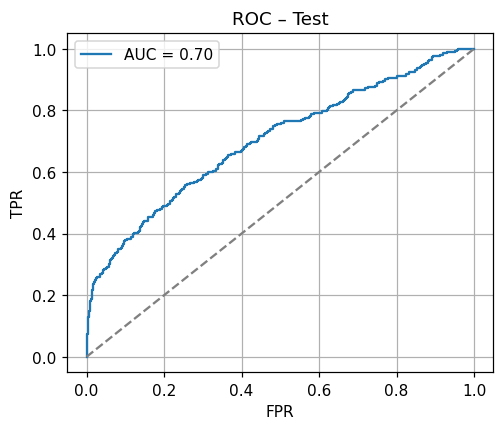

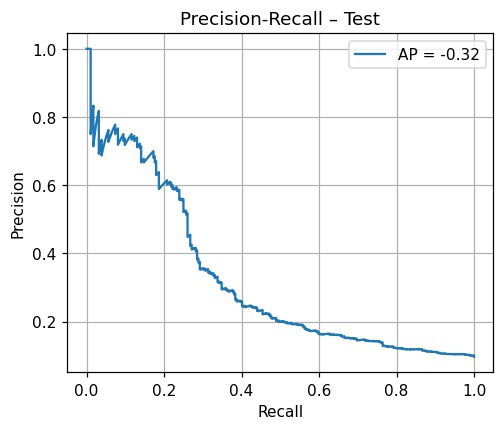

In [ ]:
# ROC & PR plots
fpr, tpr, _ = roc_curve(y_test, y_scores_test)
auc = roc_auc_score(y_test, y_scores_test)
plt.figure(figsize=(5,4));
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1],[0,1],'--',c='grey'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC – Test'); plt.legend(); plt.grid(); plt.show()

prec_test, rec_test, _ = precision_recall_curve(y_test, y_scores_test)
ap = np.trapz(prec_test, rec_test)
plt.figure(figsize=(5,4));
plt.plot(rec_test, prec_test, label=f'AP = {ap:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision‑Recall – Test'); plt.legend(); plt.grid(); plt.show()